In [1]:
import pkg_resources
# following versions need to be installed
pkg_resources.require('ete3==3.1.1', 'pandas==0.23.4', 'numpy==1.18.5', 'scipy==1.1.0', 'scikit-learn==0.19.1',
                      'tensorflow==1.13.1', 'joblib==0.13.2', 'h5py==2.10.0', 'Keras==2.3.1', 'matplotlib==3.1.3')


import warnings
warnings.filterwarnings('ignore')
import pandas as pd

import tensorflow as tf
import keras
import numpy as np

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Activation, Dense

from keras.utils.training_utils import multi_gpu_model
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.layers import Dense, Dropout
from keras.layers.core import Dense, Dropout, Activation, Flatten


Using TensorFlow backend.


In [2]:
#Reading of the input data, features (Laplacian Spectrums) and parameters
cutoff=1000000 #all

param_train = pd.read_csv('.', nrows=cutoff, index_col=0)
param_test = pd.read_csv('.', index_col=0)
# parameter of interest: diversification rate
param_train['diversification_rate'] = param_train['birth_rate'] - param_train['extinction_rate']
param_test['diversification_rate'] = param_test['birth_rate'] - param_test['extinction_rate']

def rename_columns(df, names):
    df = df.rename(columns={i: names[i-1] for i in df.columns})
    return df


# loading tree encodings/representations
# encoding has the following structure: 1 value of tree height
# 1 value for tree height and 500 values for internal node heights
# + 1 value of rescaling (removed, but stocked for rescaling predicted values back to the original scale)
encoding_train = pd.read_csv('.', sep="\t", header=None, nrows=cutoff, index_col=0)
encoding_test = pd.read_csv('.', sep="\t", header=None, index_col=0)

#indexes:
encoding_train.index = param_train.index
encoding_test.index = param_test.index

expname='_1000000_cnn_cdv_mae'
chemin = 'full_tree/all_samp_input/'

In [3]:
print(param_train)
print(encoding_train)

         turnover_rate  birth_rate  extinction_rate  sampling_frac   R_nought  \
1                                                                               
2             0.874882    0.381373         0.333656       0.361261   1.143011   
3             0.125277    0.132268         0.016570       0.919645   7.982286   
4             0.587013    0.169996         0.099790       0.183107   1.703540   
5             0.691069    0.179670         0.124164       0.349816   1.447034   
6             0.125938    0.392451         0.049425       0.076036   7.940411   
7             0.278887    0.179020         0.049926       0.615671   3.585686   
8             0.216952    0.328559         0.071282       0.756440   4.609313   
9             0.195952    0.106037         0.020778       0.634376   5.103299   
10            0.808256    0.492445         0.398022       0.025604   1.237232   
11            0.909619    0.186279         0.169443       0.716155   1.099362   
12            0.186280    0.

In [4]:
#correctly reshape parameters (rescaling) and encodings (remove nb of each type + rescale factor):

### TRAINING SET: PARAMETER VALUES
# rescaling factor
param_train['norm_factor'] = encoding_train.iloc[:,-1]
encoding_train = encoding_train.drop(encoding_train.columns[-1], axis =1)

param_train['birth_rate_rescaled'] = param_train['birth_rate']*param_train['norm_factor']
param_train['extinction_rate_rescaled'] = param_train['extinction_rate']*param_train['norm_factor']
param_train['diversification_rate_resc'] = param_train['diversification_rate']*param_train['norm_factor']

### TESTING SET: PARAMETER VALUES
# rescaling factor
param_test['norm_factor'] = encoding_test.iloc[:,-1]
# rescale target values
encoding_test = encoding_test.drop(encoding_test.columns[-1], axis =1)
param_test['birth_rate_rescaled'] = param_test['birth_rate']*param_test['norm_factor']
param_test['extinction_rate_rescaled'] = param_test['extinction_rate']*param_test['norm_factor']
param_test['diversification_rate_resc'] = param_test['diversification_rate']*param_test['norm_factor']


#Choice of the parameters to predict
target_1 = "birth_rate_rescaled"
target_2 = "extinction_rate_rescaled"
target_3 = "turnover_rate"
target_4 = "diversification_rate_resc"
targets = pd.DataFrame(param_train[[target_1, target_2, target_3, target_4]])


#Choice of the features: in this case, all the lines
features = encoding_train
features_test = encoding_test
valid_set_nb = 10000

In [5]:
param_test.to_csv('../../Data/' + chemin + expname + 'target_all.csv', header=True)

In [6]:
#Add the known sampling fraction as 3*1 matrix into the representation (both train and test sets)
add_target = "sampling_frac"
added_targets = pd.DataFrame(param_train[add_target])
features['1001'] = added_targets
features['1002'] = added_targets
features['1003'] = added_targets

added_targets2 = pd.DataFrame(param_test[add_target])
features_test['1001'] = added_targets2
features_test['1002'] = added_targets2
features_test['1003'] = added_targets2

'\nadd_target = "transmission_rate"\nadded_targets = pd.DataFrame(parameters[add_target])\nfeatures[\'398\'] = added_targets\n\npredicted_transmission_rate = pd.read_csv(\'predicted_transmission_rate.csv\')\n\npredicted_transmission_rate = predicted_transmission_rate.drop(predicted_transmission_rate.columns[0], axis =1)\n\npredicted_transmission = predicted_transmission_rate.as_matrix()\n\npredicted_transmission = predicted_transmission.reshape(899855)\n\nfeatures[\'398\'][:899855] = predicted_transmission\n'

In [7]:
print(features.shape)
print(targets.shape)

valid_frac = valid_set_nb/features.shape[0]
train_size_frac = (features.shape[0]-valid_set_nb)/features.shape[0]

(1000000, 504)
(1000000, 4)


In [8]:
features

,1,2,3,4,5,6,7,8,9,10,...,495,496,497,498,499,500,501,1001,1002,1003
1,,,,,,,,,,,,,,,,,,,,,
2,11.700365,11.172593,10.418716,11.227841,9.991438,9.556257,9.594301,11.240674,9.482048,9.622095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.361261,0.361261,0.361261
3,10.898345,9.110271,8.257999,9.659510,7.375813,9.563730,10.299675,9.324722,9.620378,10.601697,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.919645,0.919645,0.919645
4,8.608306,7.136067,6.782000,7.108194,8.496636,6.706171,6.553076,7.814724,7.666936,6.914597,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183107,0.183107,0.183107
5,13.288767,10.610986,10.867757,13.243327,9.882245,12.212116,9.591177,9.699930,11.406177,13.009605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.349816,0.349816,0.349816
6,5.256242,3.375401,3.150304,4.740335,2.939978,2.501094,2.543208,3.650645,4.769490,2.348926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076036,0.076036,0.076036
7,11.898072,10.774114,10.709979,10.503580,10.711790,11.382613,10.383156,8.831830,11.532228,11.488162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.615671,0.615671,0.615671
8,9.510212,8.006512,9.277536,7.608777,7.035647,8.877734,8.085061,8.833743,9.396947,7.378368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.756440,0.756440,0.756440
9,12.730731,12.075164,11.700868,11.649638,11.620251,12.239691,11.894291,11.544252,11.776421,10.009469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.634376,0.634376,0.634376
10,6.950933,5.560178,5.187938,4.450743,5.784711,4.315216,4.004111,5.513813,4.773289,3.617524,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025604,0.025604,0.025604


In [9]:
#Standardization of the input features

X = features
Y = targets

#Split of the Input Data into a Train and a Test DataSet
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_size_frac, shuffle = False)

In [10]:
print(features.shape)

(1000000, 504)


In [11]:
X.shape[1]

504

In [12]:
#Creation of the Network Model: model definition

def build_model():
    model = Sequential()
    
    # convolutional part
    model.add(keras.layers.Reshape((504, 1), input_shape=(X.shape[1],)))
    model.add(Conv1D(filters = 50, kernel_size=(5), input_shape= (X.shape[1],), activation='elu'))
    model.add(Conv1D(filters = 50, kernel_size=(10), activation='elu'))
    model.add(MaxPooling1D(10))
    model.add(Conv1D(filters = 80, kernel_size=(10), activation='elu'))
    # flattening the 2D 'feature maps' into 1D vector used in 'FFNN part'
    model.add(GlobalAveragePooling1D())
    # FFNN part
    keras.layers.Dropout(0.5)
    model.add(Dense(64, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(32, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(16, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(8, activation='elu'))
    keras.layers.Dropout(0.5)
    # output layer with 4 output neurons = nb of target parameters 
    model.add(Dense(4, activation='elu'))
    # show the model structure
    model.summary()
    return model

In [13]:
#Building of the model

from keras import losses

model = build_model()

estimator = model

#Adam optimizer, loss measure: mean absolute error, metrics measured: MAPE
estimator.compile(loss='mae', optimizer = 'Adam', metrics=[losses.mean_absolute_percentage_error])

#early stopping to avoid overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

#display training progress for each completed epoch.
class PrintD(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# maximum number of EPOCHS, ie full training cycles on the whole training dataset (how many times we see the same training set)
EPOCHS = 10000

#Training of the Network, with an independent validation set
history = estimator.fit(X, Y, verbose = 1, epochs=EPOCHS, validation_split=valid_frac, batch_size=8000, callbacks=[early_stop, PrintD()])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 504, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 50)           300       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 491, 50)           25050     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 50)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 40, 80)            40080     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                5184      
__________

.Epoch 33/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.1152 - mean_absolute_percentage_error: 35.6958 - val_loss: 0.1158 - val_mean_absolute_percentage_error: 31.3565
.Epoch 34/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.1133 - mean_absolute_percentage_error: 35.2213 - val_loss: 0.1111 - val_mean_absolute_percentage_error: 33.6269
.Epoch 35/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.1122 - mean_absolute_percentage_error: 35.0181 - val_loss: 0.1154 - val_mean_absolute_percentage_error: 36.0901
.Epoch 36/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.1124 - mean_absolute_percentage_error: 35.0200 - val_loss: 0.1233 - val_mean_absolute_percentage_error: 38.2698
.Epoch 37/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.1115 - mean_absolute_percentage_error: 34.9004 - val_loss: 0.1142 - val_mean_absolute_percentage_error: 35.

.Epoch 74/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.1025 - mean_absolute_percentage_error: 32.8921 - val_loss: 0.1030 - val_mean_absolute_percentage_error: 33.8884
.Epoch 75/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.1022 - mean_absolute_percentage_error: 32.8673 - val_loss: 0.1070 - val_mean_absolute_percentage_error: 30.9720
.Epoch 76/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.1052 - mean_absolute_percentage_error: 33.6359 - val_loss: 0.1051 - val_mean_absolute_percentage_error: 35.5883
.Epoch 77/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.1000 - mean_absolute_percentage_error: 32.3446 - val_loss: 0.1018 - val_mean_absolute_percentage_error: 31.1247
.Epoch 78/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.1004 - mean_absolute_percentage_error: 32.4402 - val_loss: 0.1018 - val_mean_absolute_percentage_error: 33.

.Epoch 115/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0973 - mean_absolute_percentage_error: 31.6928 - val_loss: 0.1010 - val_mean_absolute_percentage_error: 28.8563
.Epoch 116/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.1000 - mean_absolute_percentage_error: 32.2264 - val_loss: 0.0992 - val_mean_absolute_percentage_error: 35.0022
.Epoch 117/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0973 - mean_absolute_percentage_error: 31.6327 - val_loss: 0.0970 - val_mean_absolute_percentage_error: 32.1703
.Epoch 118/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0963 - mean_absolute_percentage_error: 31.4326 - val_loss: 0.1030 - val_mean_absolute_percentage_error: 32.3158
.Epoch 119/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0978 - mean_absolute_percentage_error: 31.6916 - val_loss: 0.0980 - val_mean_absolute_percentage_error

980100/980100 [==============================] - 32s 33us/step - loss: 0.0959 - mean_absolute_percentage_error: 31.2591 - val_loss: 0.0990 - val_mean_absolute_percentage_error: 32.3008
.Epoch 196/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0936 - mean_absolute_percentage_error: 30.7770 - val_loss: 0.0975 - val_mean_absolute_percentage_error: 28.6126
.Epoch 197/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0929 - mean_absolute_percentage_error: 30.6287 - val_loss: 0.0965 - val_mean_absolute_percentage_error: 28.4359
.Epoch 198/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0947 - mean_absolute_percentage_error: 30.9445 - val_loss: 0.0967 - val_mean_absolute_percentage_error: 31.4335
.Epoch 199/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0941 - mean_absolute_percentage_error: 30.8506 - val_loss: 0.0952 - val_mean_absolute_percentage_error: 30.3110
.Epoch 

980100/980100 [==============================] - 32s 33us/step - loss: 0.0922 - mean_absolute_percentage_error: 30.3642 - val_loss: 0.0939 - val_mean_absolute_percentage_error: 29.7201
.Epoch 276/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0938 - mean_absolute_percentage_error: 30.8148 - val_loss: 0.0946 - val_mean_absolute_percentage_error: 28.6424
.Epoch 277/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0922 - mean_absolute_percentage_error: 30.3244 - val_loss: 0.0951 - val_mean_absolute_percentage_error: 31.9234
.Epoch 278/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0919 - mean_absolute_percentage_error: 30.3120 - val_loss: 0.0947 - val_mean_absolute_percentage_error: 30.8064
.Epoch 279/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0927 - mean_absolute_percentage_error: 30.4855 - val_loss: 0.0941 - val_mean_absolute_percentage_error: 29.4169
.Epoch 

980100/980100 [==============================] - 32s 33us/step - loss: 0.0912 - mean_absolute_percentage_error: 30.1540 - val_loss: 0.0955 - val_mean_absolute_percentage_error: 34.1495
.Epoch 356/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0909 - mean_absolute_percentage_error: 30.0806 - val_loss: 0.0934 - val_mean_absolute_percentage_error: 30.7886
.Epoch 357/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0907 - mean_absolute_percentage_error: 30.0802 - val_loss: 0.0938 - val_mean_absolute_percentage_error: 32.2942
.Epoch 358/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0919 - mean_absolute_percentage_error: 30.3643 - val_loss: 0.0947 - val_mean_absolute_percentage_error: 28.2002
.Epoch 359/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0908 - mean_absolute_percentage_error: 30.0867 - val_loss: 0.0937 - val_mean_absolute_percentage_error: 29.7058
.Epoch 

980100/980100 [==============================] - 32s 33us/step - loss: 0.0902 - mean_absolute_percentage_error: 29.8806 - val_loss: 0.0964 - val_mean_absolute_percentage_error: 32.3796
.Epoch 436/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0901 - mean_absolute_percentage_error: 29.9228 - val_loss: 0.0945 - val_mean_absolute_percentage_error: 30.1929
.Epoch 437/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0902 - mean_absolute_percentage_error: 29.9320 - val_loss: 0.0947 - val_mean_absolute_percentage_error: 28.4239
.Epoch 438/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0903 - mean_absolute_percentage_error: 29.9318 - val_loss: 0.0932 - val_mean_absolute_percentage_error: 31.3136
.Epoch 439/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0902 - mean_absolute_percentage_error: 29.9379 - val_loss: 0.0939 - val_mean_absolute_percentage_error: 32.2016
.Epoch 

980100/980100 [==============================] - 32s 33us/step - loss: 0.0899 - mean_absolute_percentage_error: 29.8440 - val_loss: 0.0943 - val_mean_absolute_percentage_error: 30.7970
.Epoch 516/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0894 - mean_absolute_percentage_error: 29.7061 - val_loss: 0.0935 - val_mean_absolute_percentage_error: 31.9462
.Epoch 517/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0894 - mean_absolute_percentage_error: 29.8054 - val_loss: 0.0936 - val_mean_absolute_percentage_error: 28.6286
.Epoch 518/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0898 - mean_absolute_percentage_error: 29.7933 - val_loss: 0.0928 - val_mean_absolute_percentage_error: 29.6074
.Epoch 519/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0897 - mean_absolute_percentage_error: 29.8833 - val_loss: 0.0939 - val_mean_absolute_percentage_error: 28.3494
.Epoch 

980100/980100 [==============================] - 32s 33us/step - loss: 0.0892 - mean_absolute_percentage_error: 29.7489 - val_loss: 0.0960 - val_mean_absolute_percentage_error: 27.6552
.Epoch 596/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0894 - mean_absolute_percentage_error: 29.7179 - val_loss: 0.0936 - val_mean_absolute_percentage_error: 29.7420
.Epoch 597/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0888 - mean_absolute_percentage_error: 29.6555 - val_loss: 0.0940 - val_mean_absolute_percentage_error: 29.3494
.Epoch 598/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0894 - mean_absolute_percentage_error: 29.8095 - val_loss: 0.0945 - val_mean_absolute_percentage_error: 28.2172
.Epoch 599/10000
980100/980100 [==============================] - 32s 33us/step - loss: 0.0891 - mean_absolute_percentage_error: 29.7098 - val_loss: 0.0952 - val_mean_absolute_percentage_error: 31.9001
.Epoch 

In [14]:
import matplotlib.pyplot as plt

#Plot the loss of the Training and the Validation sets, to monitor the evolution of the loss, and to spot a prospective over fitting

def plot_history(history):
    plt.figure(figsize = (30, 20))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['loss']), 
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_percentage_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0,30])
    #plt.savefig('../Plots_per/' + chemin + 'loss_evolution_int.png')
    plt.show()
  #plt.savefig('results_20181023_BD_basic/DL_results/eigen_loss_evolution_all.png')

plot_history(history)

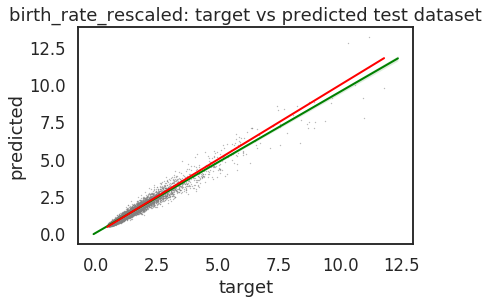

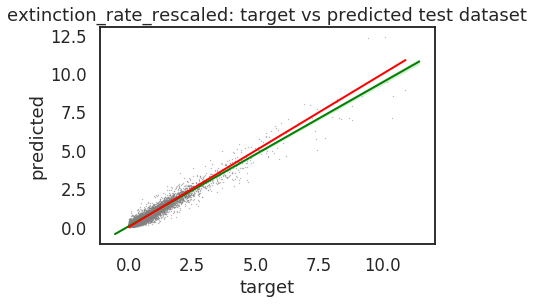

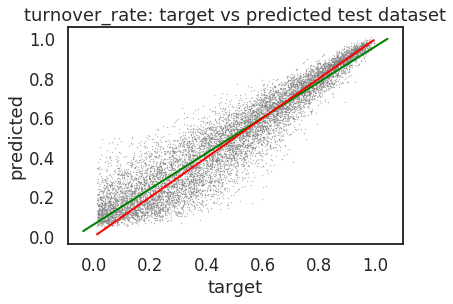

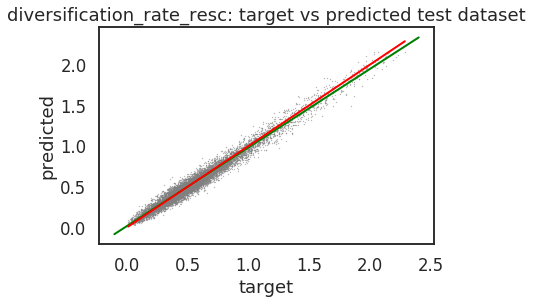

In [15]:
import seaborn as sns
#import statsmodel.formula.api as smf
import matplotlib.pyplot as plt

#Plot test vs predicted
# predict values for the test set
predicted_test = pd.DataFrame(estimator.predict(X_test))
predicted_test.columns = Y_test.columns # rename correctly the columns
predicted_test.index = Y_test.index # rename indexes for correspondence

elts = []

# just for subsetting columns more automatically + naming output plots
for elt in Y_test.columns:
    elts.append(elt)

for elt in elts:
    sub_df = pd.DataFrame({'predicted_minus_target_' + elt: predicted_test[elt] - Y_test[elt], 'target_'+elt: Y_test[elt], 'predicted_'+elt: predicted_test[elt]})
    if elt == elts[0]:
        df = sub_df
    else:
        sub_df.index = df.index
        df = pd.concat([df, sub_df], axis=1)

# fast plotting for analysis (with seaborn):
def target_vs_predicted(target_name, predicted_name, param_name, file_name_beg) : 
    sns.set_style('white')
    sns.set_context('talk')
    sns.regplot(x=target_name, y=predicted_name, data=df, ci=95, n_boot=500, 
                scatter_kws={'s':0.1, 'color':'grey'}, line_kws={ 'color':'green', 'linewidth':2})
    plt.title(param_name + ': target vs predicted test dataset')
    plt.xlabel('target')
    plt.ylabel('predicted')
    innerlimit = min(df[target_name])
    
    outerlimit = max(df[target_name])
    plt.plot([innerlimit, outerlimit], [innerlimit, outerlimit], linewidth=2, color='red')
    plt.show()
    return None

    
for elt in elts:
    target_vs_predicted('target_'+elt, 'predicted_'+elt, elt, file_name_beg=elt)

In [16]:
# rescale back
predicted_test['birth_rate'] = predicted_test['birth_rate_rescaled']/param_test['norm_factor']
predicted_test['extinction_rate'] = predicted_test['extinction_rate_rescaled']/param_test['norm_factor']
predicted_test['diversification_rate'] = predicted_test['diversification_rate_resc']/param_test['norm_factor']

In [17]:
# table with statistics on errors
errors_index = elts
errors_columns = ['MAE', 'RMSE', 'RME']
errors = pd.DataFrame(index=errors_index, columns=errors_columns)

def get_mae_rmse(name_var):
    predicted_vals = df['predicted_' + name_var]
    target_vals = df['target_' + name_var]
    diffs_abs = abs(target_vals - predicted_vals)
    diffs_rel = diffs_abs/target_vals
    diffs_abs_squared = diffs_abs**2
    mae = np.sum(diffs_abs)/len(diffs_abs)
    rmse = np.sqrt(sum(diffs_abs_squared)/len(diffs_abs_squared))
    rme = np.sum(diffs_rel)/len(diffs_rel)
    return mae, rmse, rme
    

#errors.loc['R_nought'] = np.array(get_mae_rmse('R_nought'))
for elt in errors_index:
    errors.loc[elt] = np.array(get_mae_rmse(elt))

print(errors)

                                 MAE       RMSE        RME
birth_rate_rescaled         0.111695   0.182835  0.0824046
extinction_rate_rescaled    0.139155   0.214527   0.605929
turnover_rate              0.0703593  0.0944886   0.478721
diversification_rate_resc  0.0431375  0.0557914   0.102244


In [ ]:
###save the model, weights (and scaler for sumstats only)

from keras.models import model_from_json

# save model
model_trial_1000 = model.to_json()
with open('../Model/' + chemin + 'model_all' + expname + '.json','w') as json_file:
    json_file.write(model_trial_1000)

# save weights
model.save_weights('../Model/' + chemin + 'model_all_weights' + expname +'.h5')
print('model saved!')

'''
#load the model
json_file = open('../Model/' + chemin + 'model_all' + expname + '.json', 'r')
loaded_file = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_file)
#load weights
loaded_model.load_weights(../Model/' + chemin + 'model_all_weights' + expname +'.h5'5)
print('model loaded!')

'''

#save scaler when there is one (FFNN-SS)
"""
from sklearn.externals import joblib

scale_filename = '../../Model/' + chemin + 'all_standardscaler' + expname + '.pkl'
joblib.dump(scale, scale_filename)

print('scale saved!')
#load scaler:
#scale = joblib.load(scale_filename)
"""


In [19]:
####save the predicted and the target dataframes
Y_test.to_csv('../../Data/' + chemin + expname + 'target_all.csv', header=True)

predicted_test.to_csv('../../Data/' + chemin + expname + 'predicted_all.csv', header=True)

